# Test Suit 2 - LLM performance test - est. time (5 hrs)
### Importing required dependencies.
pip install any required libraries as needed

In [ ]:
import json
import re
import requests
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from difflib import SequenceMatcher
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns



### Labeled Dataset with combined querys.
#### class 0 - Queries related to movies that reqiure json response.
#### class 1 - Queries not related movies that require text response. 
### Import as pandas.df and create a random sample of size 200 for testing. 
(reduce n if you want faster tests.)

In [4]:
df = pd.read_csv("./../LLM_training_data/Labeled_Dataset.csv")
prompts = df.sample(n=200, random_state=42).reset_index(drop=True)


### Helper fucntion to extract json from string

In [ ]:
def remove_escape_sequences(text: str) -> str:
    return re.sub(r'[\x00-\x1F\x7F]+', '', text)


def extract_full_curly_block(text: str) -> str:
    start = text.find('{')
    end = text.rfind('}')
    if start != -1 and end != -1 and end > start:
        return text[start:end + 1]
    return ""


def extract_json_from_string(text):
    no_break_text = remove_escape_sequences(text)
    proto_json = extract_full_curly_block(no_break_text)
    if not proto_json:
        return False, {}
    try:
        data = json.loads(proto_json)
        if isinstance(data, dict) and data.get("positive_query") is not None:
            return True, data
    except json.JSONDecodeError:
        return False, {}
    return False, {}


### Helper function to find cosine and jaccard similarites

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")

def compute_cosine_similarity(a, b):
    embeddings = model.encode([a, b])
    return float(cosine_similarity([embeddings[0]], [embeddings[1]])[0][0])

def jaccard_similarity(str1, str2):
    tokens1 = set(re.findall(r'\w+', str1.lower()))
    tokens2 = set(re.findall(r'\w+', str2.lower()))
    union = tokens1.union(tokens2)
    intersection = tokens1.intersection(tokens2)
    return len(intersection) / len(union) if union else 0


### Custom Funtion for matching how similar JSON files are. - comments to help

In [ ]:
def calculate_matching_score(expected_json, produced_json):
    # Helper function to recursively compare two dictionaries
    def compare_dicts(dict1, dict2):
        matching_score = 0
        total_keys = len(dict1) + len(dict2)

        if total_keys == 0:
            return 1  # If both dictionaries are empty, it's a perfect match
        
        # Check for key matching
        common_keys = dict1.keys() & dict2.keys()
        matching_score += len(common_keys)

        # Compare values for common keys
        for key in common_keys:
            if dict1[key] == dict2[key]:
                matching_score += 1  # Full match
            elif isinstance(dict1[key], dict) and isinstance(dict2[key], dict):
                # Recursively compare nested dictionaries
                matching_score += compare_dicts(dict1[key], dict2[key])
        
        # Return the proportion of matching keys and values
        return matching_score / total_keys

## Function which calculates all the scores for given response.

In [ ]:
def exact_match_ratio(a, b):
    return SequenceMatcher(None, a, b).ratio()
    
def evaluate_response(user_prompt, expected_response, generated_content):
    metrics = {
        "valid_json": None,
        "json_key_count": None,
        "has_positive_query": None,
        "has_negative_query": None,
        "has_row_checker": None,
        "row_checker_fields": None,
        "cosine_sim": None,
        "jaccard_sim": None,
        "exact_match": None,
        "checkjson": None,  
    }


    correct_json, checkjson = extract_json_from_string(expected_response)
    is_json, parsed = extract_json_from_string(generated_content)
    metrics["checkjson"] = checkjson
    metrics["valid_json"] = is_json
    if checkjson and is_json:
        metrics["json_key_count"] = len(parsed)
        metrics["has_positive_query"] = "positive_query" in parsed
        metrics["has_negative_query"] = "negative_query" in parsed
        metrics["has_row_checker"] = "row_checker" in parsed
        metrics["matching_score"] = calculate_matching_score(is_json, correct_json)

    metrics["cosine_sim"] = compute_cosine_similarity(expected_response, generated_content)
    metrics["jaccard_sim"] = jaccard_similarity(expected_response, generated_content)
    metrics["exact_match"] = exact_match_ratio(expected_response, generated_content)

    return metrics



### Declaring LLM models and API request address, make sure your flask server is on, before running this test suit

In [9]:
GROQ_API = "http://localhost:5000/run-groq"
OLLAMA_API = "http://localhost:5000/run-local-gemma"
LLM_MODELS = {
    "groq": GROQ_API,
    "gemma2:2b": OLLAMA_API,
    "gemma:2b": OLLAMA_API,
    "gemma-json": OLLAMA_API    
}


## Code for running test suit on each LLM and saving the results

In [ ]:
import time
import pandas as pd
import requests
from tqdm import tqdm

all_results = []

for model_name, api_url in LLM_MODELS.items():
    print(f"Evaluating model: {model_name}")
    
    # Track start time for the entire model evaluation
    start_time = time.time()
    
    model_results = []

    # Iterate over the prompts and evaluate each one
    # Using tqdm to show progress bar
    for _, row in tqdm(prompts.iterrows(), total=prompts.shape[0]):
        user_prompt = row["user_prompt"]
        expected_response = row["response"]
        catagory = row["category"]
        checkjson = catagory == "json"

        messages = [
            {
                "role": "system",
                "content": (
                    "If the user asks something other than movies promptly ask the user to rephrase the question and ask for movie recommendations.\n"
                    "You are an assistant that takes a movie-related user prompt and extracts:\n"
                    "1. A positive_query: A string with words related what the user wants actors, places, themes plots etc. ( do not mention any actual movie and do not leave empty).\n"
                    "2. A negative_query: A string describing actors or themes the user wants to avoid.\n"
                    "3. A row_checker object that may include any of the following optional filters (do not put too many restrictions, only what user asked for):\n"
                    "   - min_year (integer)\n"
                    "   - max_year (integer)\n"
                    "   - min_rating (float)\n"
                    "   - max_rating (float)\n"
                    "   - min_duration (integer, in minutes)\n"
                    "   - max_duration (integer, in minutes)\n"
                    "   - required_genres (list of strings)\n"
                    "   - excluded_genres (list of strings)\n"
                    "   - required_languages (list of strings)\n"
                    "   - excluded_languages (list of strings)\n"
                    "If the prompt is asking for movie recommendation return ONLY a valid JSON object with keys: positive_query, negative_query, row_checker.\n"
                )
            },
            {
                "role": "user",
                "content": user_prompt
            }
        ]
        payload = {"messages": messages}
        if "gemma" in model_name:
            payload["model"] = model_name

        try:
            res = requests.post(api_url, json=payload)
            generated_content = res.json().get("response", "")
        except Exception as e:
            generated_content = f"Error: {e}"

        # Evaluate the response and calculate metrics
        metrics = evaluate_response(user_prompt, expected_response, generated_content)
        metrics.update({
            "model": model_name,
            "user_prompt": user_prompt,
            "expected_response": expected_response,
            "category": catagory,
            "generated_content": generated_content,
        })
        # Add the mertrics to the list of results
        model_results.append(metrics)

    # Create a DataFrame from the results and append to all_results
    results_df = pd.DataFrame(model_results)
    all_results.append(results_df)

    # Track end time for the entire model evaluation
    end_time = time.time()
    total_time = end_time - start_time
    average_time = total_time / len(prompts)

    print(f"Total time for model {model_name}: {total_time:.2f} seconds")
    print(f"Average time per prompt for model {model_name}: {average_time:.2f} seconds")



Evaluating model: groq


100%|██████████| 200/200 [09:05<00:00,  2.73s/it]


Total time for model groq: 545.45 seconds
Average time per prompt for model groq: 2.73 seconds
Evaluating model: gemma2:2b


100%|██████████| 200/200 [1:05:52<00:00, 19.76s/it]


Total time for model gemma2:2b: 3952.88 seconds
Average time per prompt for model gemma2:2b: 19.76 seconds
Evaluating model: gemma:2b


100%|██████████| 200/200 [1:51:49<00:00, 33.55s/it]  


Total time for model gemma:2b: 6709.99 seconds
Average time per prompt for model gemma:2b: 33.55 seconds
Evaluating model: gemma-json


100%|██████████| 200/200 [1:52:50<00:00, 33.85s/it]  

Total time for model gemma-json: 6770.26 seconds
Average time per prompt for model gemma-json: 33.85 seconds


# Function Code to plot similary graphs comparing each model. 

### 1. Creates bar graphs with average similarity scores for each model 
### 2. Generate confusion matrices with the JSON(1) - NON-JSON(0)classes

In [ ]:
def compute_model_wise_averages(all_results):
    # Combine all model results into a single df, convert boolean columns to int, and compute averages
    combined_df = pd.concat(all_results, ignore_index=True)


    bool_cols = combined_df.select_dtypes(include=["bool"]).columns
    combined_df[bool_cols] = combined_df[bool_cols].astype(int)


    relevant_columns = ['cosine_sim', 'jaccard_sim', 'exact_match']
    model_averages = combined_df[relevant_columns].groupby(combined_df["model"]).mean(numeric_only=True).reset_index()

    # Plot bar graphs for the scores 
    model_averages.set_index('model', inplace=True)
    ax = model_averages.plot(kind='bar', figsize=(10, 6))
    plt.title("Model Comparison on Cosine Similarity, Jaccard Similarity, and Exact Match")
    plt.ylabel('Scores')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    fontsize=10, color='black', 
                    xytext=(0, 5), textcoords='offset points')

    plt.show()


    confusion_matrices = {}

    # Compute confusion matrix for each model
    if 'checkjson' in combined_df.columns and 'valid_json' in combined_df.columns:
        for model, group in combined_df.groupby('model'):
            group['checkjson'] = group['checkjson'].apply(lambda x: 1 if x else 0)
            group['valid_json'] = group['valid_json'].apply(lambda x: 1 if x else 0)

            reality = group['checkjson']
            prediction = group['valid_json']
            
            # Check for any missing values
            if reality.isnull().any() or prediction.isnull().any():
                print(f"Warning: Missing values found for model {model}, skipping confusion matrix.")
                continue

            if len(reality.unique()) > 1 and len(prediction.unique()) > 1:
                cm = confusion_matrix(reality, prediction, labels=[0, 1])
                cm_df = pd.DataFrame(cm, columns=['Pred_0', 'Pred_1'], index=['True_0', 'True_1'])
                confusion_matrices[model] = cm_df

                # Plotting the confusion matrix as a heatmap
                plt.figure(figsize=(5, 4))
                sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", xticklabels=cm_df.columns, yticklabels=cm_df.index)
                plt.title(f"Confusion Matrix for {model}")
                plt.ylabel('Actual')
                plt.xlabel('Predicted')
                plt.show()
            else:
                print(f"Warning: Only one class found for model {model}, skipping confusion matrix.")
                confusion_matrices[model] = None
    else:
        confusion_matrices = None

    return model_averages, confusion_matrices


### Finds percentage of times PositiveQuery, Negative Query and Row_checker appered, as these are 3 required fields. 

In [ ]:


def compute_field_percentages_per_model(all_results):
    # Combine into DataFrame
    df = pd.concat(all_results, ignore_index=True)

    bool_fields = [
        "valid_json", "checkjson",
        "has_positive_query", "has_negative_query", "has_row_checker"
    ]
    for col in bool_fields:
        df[col] = df[col].astype(bool)

    # Replace None with pd.NA for better handling of missing values
    df = df.replace({None: pd.NA})

    results = []

    # Group by model and calculate percentages
    for model, group in df.groupby("model"):
        checkjson_group = group[group["checkjson"] == True]
        cj_total = len(checkjson_group)
        cj_pos = checkjson_group["has_positive_query"].sum() if cj_total else 0
        cj_neg = checkjson_group["has_negative_query"].sum() if cj_total else 0
        cj_row = checkjson_group["has_row_checker"].sum() if cj_total else 0

        valid_group = group[group["valid_json"] == True]
        v_total = len(valid_group)
        v_pos = valid_group["has_positive_query"].sum() if v_total else 0
        v_neg = valid_group["has_negative_query"].sum() if v_total else 0
        v_row = valid_group["has_row_checker"].sum() if v_total else 0

        results.append({
            "model": model,
            "checkjson_count": cj_total,
            "checkjson_positive_query_%": round(100 * cj_pos / cj_total, 2) if cj_total else 0,
            "checkjson_negative_query_%": round(100 * cj_neg / cj_total, 2) if cj_total else 0,
            "checkjson_row_checker_%": round(100 * cj_row / cj_total, 2) if cj_total else 0,
            "valid_json_count": v_total,
            "valid_positive_query_%": round(100 * v_pos / v_total, 2) if v_total else 0,
            "valid_negative_query_%": round(100 * v_neg / v_total, 2) if v_total else 0,
            "valid_row_checker_%": round(100 * v_row / v_total, 2) if v_total else 0,
        })

    results_df = pd.DataFrame(results)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    columns = [
        "checkjson_positive_query_%", "checkjson_negative_query_%", "checkjson_row_checker_%",
        "valid_positive_query_%", "valid_negative_query_%", "valid_row_checker_%"
    ]
    
    # Plotting each column in a separate subplot
    for i, col in enumerate(columns):
        ax = axes[i // 3, i % 3]
        results_df.plot(kind='bar', x='model', y=col, ax=ax, legend=False)
        ax.set_title(f'{col}')
        ax.set_ylabel('Percentage (%)')
        ax.set_xlabel('Model')
        ax.set_xticklabels(results_df['model'], rotation=45)
        
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}%', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        fontsize=10, color='black', 
                        xytext=(0, 5), textcoords='offset points')

    plt.tight_layout()
    plt.show()

    return results_df


# Running functions to plot all results.

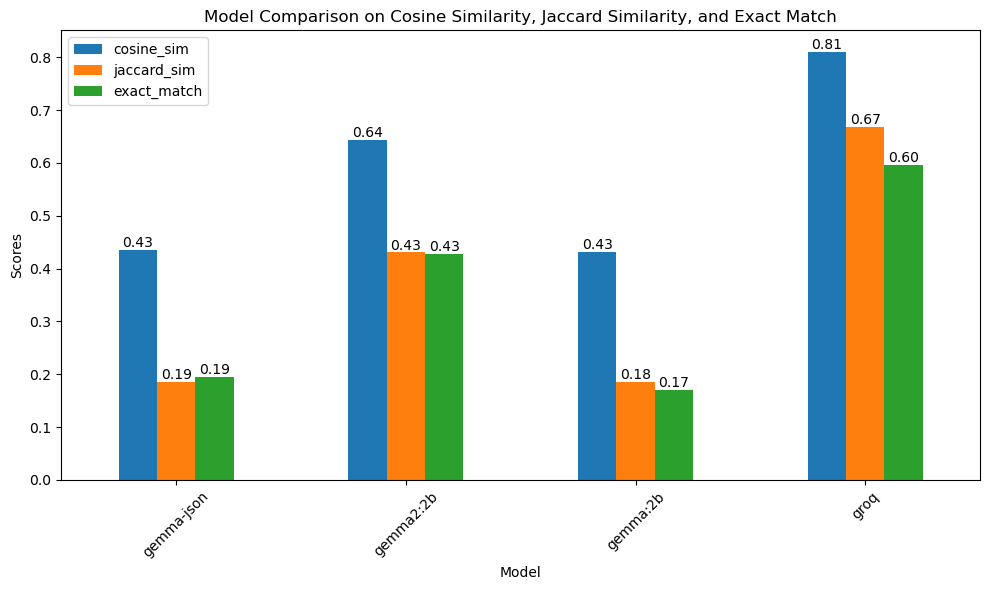

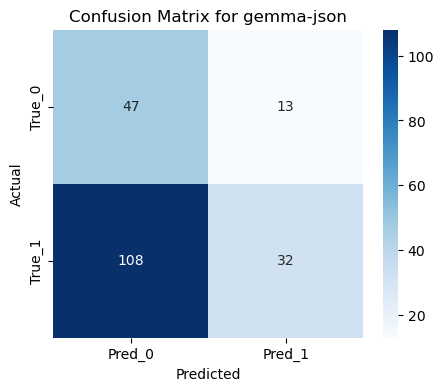

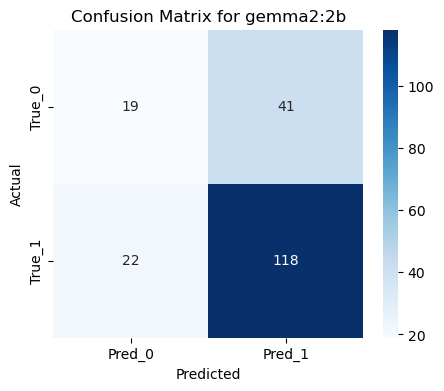

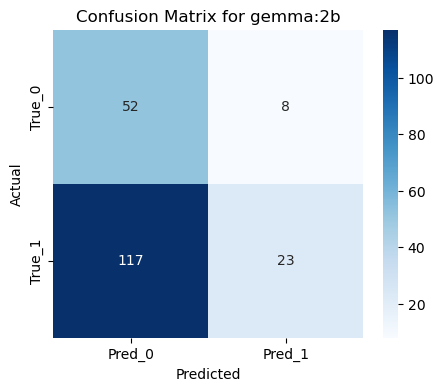

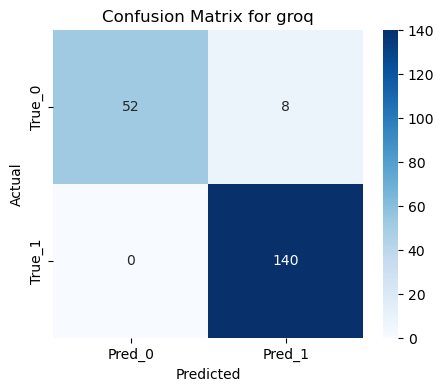

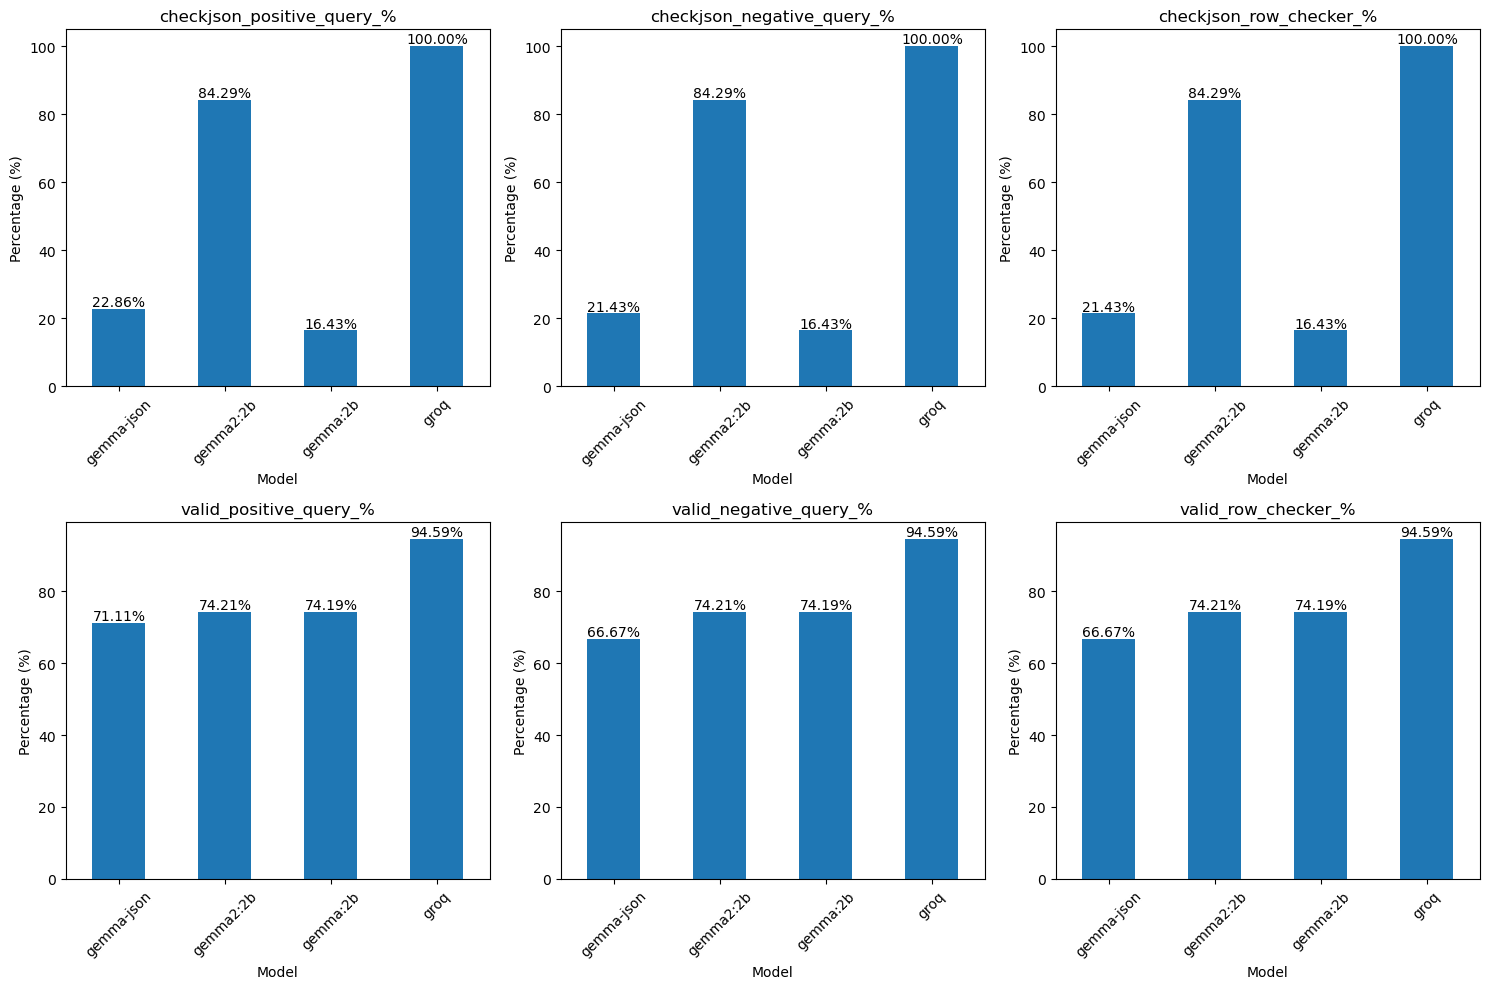

In [18]:
model_averages, cm_df = compute_model_wise_averages(all_results)
percentcheck = compute_field_percentages_per_model(all_results)